# Visualization of the generation of a MARIDA L1C patch from a Copernicus Hub L1C patch

MARIDA is a dataset containing Sentinel-2 L1C images without band B09 and B10 and that are also processed with an atmospheric correction. This notebook visualizes the generation of a pre-processed L1C image band of a MARIDA patch, which is cropped starting from the patch downloaded from Copernicu Hub.

In [141]:
import numpy as np
path = './img_cop_hub_img_marida_matches.npz'
npz = np.load(path)
npz.files

['keypoints0', 'keypoints1', 'matches', 'match_confidence']

In [142]:
print(npz['keypoints0'].shape)

print(npz['keypoints1'].shape)

print(npz['matches'].shape)

print(np.sum(npz['matches']>-1))

print(npz['match_confidence'].shape)


(54, 2)
(39, 2)
(54,)
36
(54,)


In [143]:
# For each keypoint in keypoints0, the matches array indicates the index of 
# the matching keypoint in keypoints1, or -1 if the keypoint is unmatched.
num_matches = 0

diffs_x = []
diffs_y = []

for idx_keypoint_0, idx_keypoint_1 in enumerate(npz['matches']):
    # Consider only keypoints that match
    if idx_keypoint_1 != -1:
        num_matches += 1
        # Get coordinates of matched keypoints
        keypont_0_x, keypont_0_y = npz['keypoints0'][idx_keypoint_0][0], npz['keypoints0'][idx_keypoint_0][1]
        keypont_1_x, keypont_1_y = npz['keypoints1'][idx_keypoint_1][0], npz['keypoints1'][idx_keypoint_1][1]
        # Get signed horizontal and vertical differences of corrdinates of matched keypoints
        diff_x = keypont_0_x - keypont_1_x
        diff_y = keypont_0_y - keypont_1_y
        # Update lists of differences
        diffs_x.append(diff_x)
        diffs_y.append(diff_y)
# Compute the mean of horizontal and vertical differences
mean_diffs_x = np.mean(diffs_x)
mean_diffs_y = np.mean(diffs_y)
print(mean_diffs_x, mean_diffs_y)
print(diffs_x)
print(diffs_y)
# Compute the std dev of horizontal and vertical differences
std_dev_diffs_x = np.std(diffs_x)
std_dev_diffs_y = np.std(diffs_y)
print(std_dev_diffs_x)
print(std_dev_diffs_y)
# Discard differences whose value is not in the interval [mean_diff - std_dev, mean_diff + std_dev]
# and do this for both horizontal and vertical differences
i = 0
while i < len(diffs_x):
    if diffs_x[i] < mean_diffs_x - std_dev_diffs_x or diffs_x[i] > mean_diffs_x + std_dev_diffs_x \
        or diffs_y[i] < mean_diffs_y - std_dev_diffs_y or diffs_y[i] > mean_diffs_y + std_dev_diffs_y:
            del diffs_x[i]
            del diffs_y[i]
    i += 1
# Recompute the mean of the horizontal and vertical differences and round it to the nearest integer
# (since we use pixels)
mean_diffs_x = round(np.mean(diffs_x))
mean_diffs_y = round(np.mean(diffs_y))
print(mean_diffs_x, mean_diffs_y)
print(diffs_x)
print(diffs_y)
        
print(f"Total of {num_matches} matches")


19.916666 19.916666
[21.0, 20.0, 20.0, 20.0, 20.0, 20.0, 21.0, 20.0, 20.0, 19.0, 20.0, 20.0, 20.0, 20.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 20.0, 19.0, 20.0, 20.0, 21.0, 19.0]
[19.0, 20.0, 20.0, 20.0, 19.0, 20.0, 20.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 20.0, 21.0, 20.0, 20.0, 20.0, 20.0, 21.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
0.49300665
0.4330127
20 20
[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0]
[20.0, 20.0, 20.0, 20.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
Total of 36 matches


(296, 296)


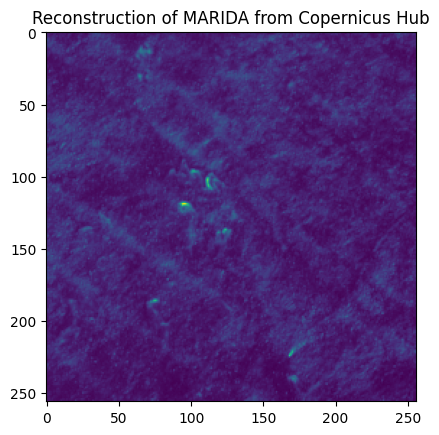

(256, 256)


In [146]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

# Crop a Copernicus Hub patch according to its shift compared to its corresponding MARIDA patch
# To do this:
# - get coordinates of the center of the MARIDA patch
# - shift them (horizontally and vertically) by the mean of differences previously computed 
# - crop the Copernicus Hub patch by considering the shifted center coordinates and the size of the MARIDA patch
MARIDA_SIZE_X = 256
MARIDA_SIZE_Y = 256

HALF_MARIDA_SIZE_X = round(MARIDA_SIZE_X / 2)
HALF_MARIDA_SIZE_Y = round(MARIDA_SIZE_Y / 2)

img = cv.imread('/data/pyraws_luca/pyraws/generate_l1c/img_to_superglue/img_cop_hub.png', cv.IMREAD_GRAYSCALE)
print(img.shape)

center_marida_x = HALF_MARIDA_SIZE_X
center_marida_y = HALF_MARIDA_SIZE_Y

corresponding_center_cop_hub_x = center_marida_x + mean_diffs_x
corresponding_center_cop_hub__y = center_marida_y + mean_diffs_y


img_new = \
    img[corresponding_center_cop_hub__y - HALF_MARIDA_SIZE_Y:corresponding_center_cop_hub__y + HALF_MARIDA_SIZE_Y,
        corresponding_center_cop_hub_x - HALF_MARIDA_SIZE_X:corresponding_center_cop_hub_x + HALF_MARIDA_SIZE_X]

plt.imshow(img_new, cmap='viridis')
plt.title("Reconstruction of MARIDA from Copernicus Hub")
plt.show()
print(img_new.shape)